In [8]:
import pandas as pd
import numpy as np
import copy
import json
import geopandas as gpd
import shapely
from shapely.geometry import box
from shapely.ops import split
from arcgis.gis import GIS
from arcgis import geocode
from arcgis.geometry import BaseGeometry, Geometry
import openai
from keybert.llm import OpenAI
from keybert import KeyLLM

In [3]:
%%time


@classmethod
def from_shapely(cls, shapely_geometry):
    return cls(shapely_geometry.__geo_interface__)

BaseGeometry.from_shapely = from_shapely


# init GIS connection
with open("agol_account_info.txt", "r") as f:
    url, username, password = f.read().splitlines()
    
gis = GIS(url, username=username, password=password)

# init llm connection
with open("openai_api_key", "r") as f:
    MY_API_KEY = f.readline()
    
    
# Create your LLM
client = openai.OpenAI(api_key=MY_API_KEY)
llm = OpenAI(client)

# Load it in KeyLLM
kw_model = KeyLLM(llm)



stop_words = ['region', 'location', 'geographical location', 'street', 'streets', 'landmarks', 'area', 'part']
directional_predictates = ['north', 'south', 'west', 'east']
arcgis_community_boundaries_lyr = gis.content.get("23a806fb906e428cb75d123cf2ab580c").layers[0]
community_boundaries_sdf = pd.DataFrame.spatial.from_layer(arcgis_community_boundaries_lyr)
fset = arcgis_community_boundaries_lyr.query()
gjson_string = fset.to_geojson
community_boundaries_gdf = gpd.read_file(gjson_string, driver='GeoJSON').set_crs(2230, allow_override=True)
sd_roads_gdf = gpd.read_file('sd_roads.json', driver='GeoJSON').set_crs(2230, allow_override=True)

Wall time: 5min 16s


In [9]:
def get_extent(geom_id, geom_txt):
    if geom_id == 0:
        return get_community(geom_txt)
    elif geom_id == 1:
        return get_poi(geom_txt)
    elif geom_id == 2:
        return get_road(geom_txt)
    else:
        raise Exception("Invalid geom_id")


def get_community(geom_txt):
    
    keywords = kw_model.extract_keywords(geom_txt)[0]
    dw_out = []
    community_out = []
    for kw in copy.deepcopy(keywords):
        for dw in directional_predictates:
            if dw in kw.lower():
                dw_out.append(dw)
                keywords.remove(kw)


    for kw in keywords:    
        kw_community = community_neighborhoods_df[
            community_neighborhoods_df.apply(
                lambda row: kw.lower() in row['community'].lower(), 
                axis = 1)
        ]
        if len(kw_community):
            community_out.append(kw)

    geocode_out = []
    for kw in community_out:
        geocode_out.append(geocode(address = kw, max_locations = 10))
        
        
    for g_out in geocode_out[0]:
        p = g_out['location']
        p = gpd.GeoSeries(shapely.Point(p['x'],  p['y'])).set_crs(4326).to_crs(2230)
        temp_gdf = community_boundaries_gdf[community_boundaries_gdf.geometry.contains(p[0])]
        if len(temp_gdf):
            # the geocode out are ranked in confidence score
            # break the first outcome is found
            break
    
    community_shape = temp_gdf.geometry.iloc[0]
    x,y = community_shape.centroid.x, community_shape.centroid.y
    minx, miny, maxx, maxy = community_shape.bounds
    
    
    l1 = shapely.LineString([(x, miny), (x, maxy)])
    l2 = shapely.LineString([(minx, y), (maxx, y)])
    
    out_poly = []
    for dw in dw_out:
        if dw in ['north', 'south']:
            out_dict = dict(map(lambda i,j : (i,j) , ['south', 'north'], split(community_shape, l2).geoms))
        else:
            out_dict = dict(map(lambda i,j : (i,j) , ['south', 'north'], split(community_shape, l2).geoms))
        out_poly.append(out_dict[dw])
        
    return out_poly[0]
    

def get_poi(geom_txt):
    
    keywords = kw_model.extract_keywords(e)[0]
    for kw in keywords.copy():
        if kw.lower() in stop_words:
            keywords.remove(kw)
            
    geocode_out = geocode(address = " ".join(keywords) + ", San Diego", max_locations = 1)[0]
    return gpd.GeoSeries(shapely.Point(geocode_out['location']['x'],  geocode_out['location']['y'])).set_crs(4326).to_crs(2230).buffer(100)[0]


def get_road(geom_txt):
    keywords = kw_model.extract_keywords(geom_txt)[0]
    for kw in keywords.copy():
        if kw.lower() in stop_words:
            keywords.remove(kw)
            
    geocode_out = []
    # specify SD to be disambiguous for geocode
    for kw in keywords:
        geocode_out.append(geocode(address = kw + ", San Diego", max_locations = 1)[0]['location'])
    
    
    rd = []
    for g_out in geocode_out:
        p = gpd.GeoSeries(shapely.Point(g_out['x'],  g_out['y'])).set_crs(4326).to_crs(2230).buffer(100)
        rd.append(sd_roads_gdf[sd_roads_gdf.geometry.crosses(p[0])])
    
    out_road = []
    for r in rd:
        rd_name = r.RD20FULL.iloc[0]
        road_segments = sd_roads_gdf[sd_roads_gdf['RD20FULL'] == rd_name]['geometry'].tolist()
        temp_road = road_segments[0]
        for r in road_segments[1:]:
            temp_road = temp_road.union(r)
        out_road.append(temp_road)
        
    simple_rd = []
    for rd in out_road:
        minx, miny, maxx, maxy = rd.bounds
        if (maxy - miny) > (maxx - minx):
            x = rd.centroid.x
            simple_rd.append(shapely.LineString([(x, miny), (x, maxy)]))
        else:

            y = rd.centroid.y
            simple_rd.append(shapely.LineString([(minx, y), (maxx, y)]))
    
    
    rd_bound = []
    road = None
    for rd1 in simple_rd:
        count = 0
        for rd2 in simple_rd:
            if rd1.crosses(rd2): count += 1 
        if count == 2:
            for i, rd2 in enumerate(simple_rd):
                pt = rd1.intersection(rd2)
                if isinstance(pt, shapely.Point):
                    rd_bound.append(pt)
                else:
                    road = out_road[i]
            break
            
    idxmax = np.argmax(np.abs(np.array(rd_bound[0].bounds) - rd_bound[1].bounds))
    maxpt1, maxpt2 = rd_bound[0].xy[idxmax][0], rd_bound[1].xy[idxmax][0]
    minx, miny, maxx, maxy = road.bounds
    minx, maxx = min(maxpt1, maxpt2), max(maxpt1, maxpt2)
    
    out_road = box(minx, miny, maxx, maxy).intersection(road)
    
    return out_road.buffer(100)

In [11]:
%%time
study_area = get_extent(0, "south La Jolla")

Wall time: 1.36 s


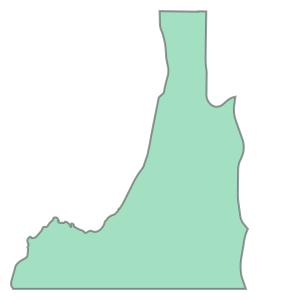

In [38]:
study_area

In [16]:
%%time
bgs_gdf = gpd.read_file("bgs_sd_imp/bgs_sd_imp.shp")

Wall time: 3min 3s


In [26]:
bgs_gdf = bgs_gdf.to_crs(2230)

In [37]:
bgs_gdf[bgs_gdf.geometry.intersects(study_area)]

,statefp,countyfp,tractce,blkgrpce,source_cou,aggregatio,population,apportionm,has_data,x2001_a,...,val400k_fy,val500k_fy,val750k_fy,val1m_fy,medval_fy,avgval_fy,valbase_fy,wlthindxcy,sei_cy,geometry
135,06,073,008313,1,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,1796.19,...,0.0,2.0,17.0,137.0,1623810.0,1656250.0,364.0,354.0,73.8,"POLYGON ((6259052.949 1886344.428, 6258862.288..."
208,06,073,008362,1,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,738.51,...,4.0,165.0,100.0,7.0,703788.0,741873.0,283.0,72.0,52.6,"POLYGON ((6259136.041 1890294.828, 6259123.887..."
216,06,073,008303,1,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,1622.09,...,0.0,1.0,6.0,15.0,2000001.0,2026748.0,472.0,339.0,65.4,"POLYGON ((6249332.460 1883793.922, 6249310.051..."
254,06,073,008303,3,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,1390.43,...,0.0,2.0,0.0,23.0,2000001.0,1996739.0,230.0,312.0,64.3,"POLYGON ((6252475.934 1883562.204, 6252416.063..."
257,06,073,008310,1,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,1837.34,...,1.0,2.0,0.0,234.0,1443376.0,1530166.0,421.0,358.0,74.7,"POLYGON ((6259384.121 1880034.105, 6259365.558..."
297,06,073,008312,3,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,1685.39,...,0.0,0.0,0.0,35.0,2000001.0,2040941.0,287.0,271.0,80.5,"POLYGON ((6255264.472 1891660.832, 6255235.036..."
298,06,073,008361,2,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,656.82,...,86.0,3.0,0.0,28.0,423256.0,506057.0,194.0,52.0,51.4,"POLYGON ((6259648.031 1894462.044, 6259546.727..."
411,06,073,008312,4,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,1515.54,...,0.0,0.0,5.0,42.0,2000001.0,1959332.0,292.0,265.0,67.4,"POLYGON ((6249775.944 1889838.106, 6249749.923..."
412,06,073,008305,1,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,413.77,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,"POLYGON ((6257196.384 1897808.426, 6257146.358..."
519,06,073,008313,2,USA,BlockApportionment:US.BlockGroups;PointsLayer:...,2.191,2.576,1,2131.94,...,0.0,1.0,9.0,82.0,1766667.0,1759091.0,440.0,479.0,66.3,"POLYGON ((6256384.925 1889477.868, 6255596.263..."


0    POLYGON ((6255296.994 1903638.439, 6256089.003...
dtype: geometry

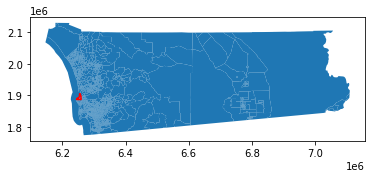

In [29]:
from matplotlib import pyplot as plt
fig, axs = plt.subplots()

bgs_gdf.plot(ax = axs)
plt.plot(*study_area.exterior.xy, color = 'red')